## Regression Implementation (Predicting TotalPrice)

✅ YearMonth is used as a numerical trend indicator (not one-hot encoded)

✅ Country_Encoded is used as a numeric label, since Random Forest handles categorical variables.

✅ No one-hot encoding is applied here because regression with Random Forest can handle numerical categorical variables well.

### Step 1: Prepare Data for Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url, sheet_name="Online Retail")

In [4]:
# Data Cleaning
df = df.dropna(subset=["CustomerID"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df = df[df["Quantity"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["YearMonth"] = df["InvoiceDate"].dt.year * 100 + df["InvoiceDate"].dt.month  # YYYYMM format


In [5]:
# Encode Country
encoder = LabelEncoder()
df["Country_Encoded"] = encoder.fit_transform(df["Country"])

In [6]:
# Define Features & Target
X_reg = df[["Quantity", "UnitPrice", "Country_Encoded", "YearMonth"]]
y_reg = df["TotalPrice"]

# Train-Test Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

### Step 2: Train Random Forest Regressor

In [7]:
# Train Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predict & Evaluate
y_pred_reg = rf_reg.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"Random Forest Regression RMSE: {rmse:.2f}")


Random Forest Regression RMSE: 6.43


### Step 3: Feature Importance (Regression)

C:\Users\serko\AppData\Local\Temp\ipykernel_21940\667592065.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_reg, palette="Blues_r")


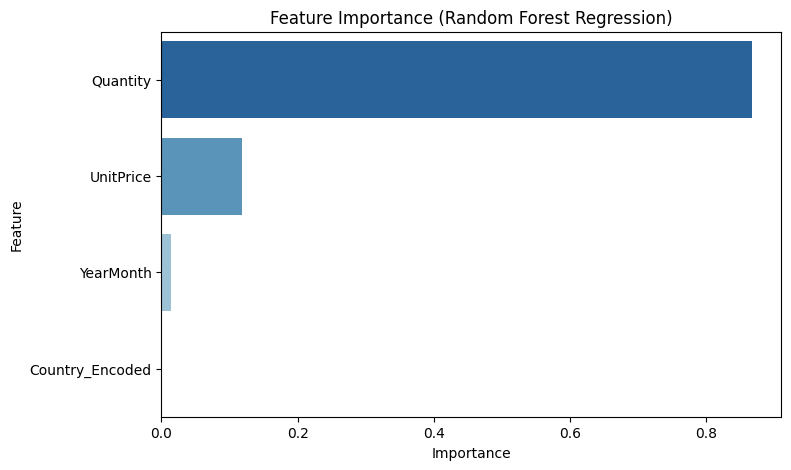

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
feature_importance_reg = pd.DataFrame({
    "Feature": X_reg.columns,
    "Importance": rf_reg.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_reg, palette="Blues_r")
plt.title("Feature Importance (Random Forest Regression)")
plt.show()
